<a href="https://colab.research.google.com/github/nanochiplab/Sayisal_Goruntu/blob/main/Odev_MedGaussBlurr.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cloning into 'AI-for-Medicine-Specialization'...
remote: Enumerating objects: 1601, done.
remote: Counting objects: 100% (28/28), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 1601 (delta 9), reused 2 (delta 0), pack-reused 1573 (from 1)
Receiving objects: 100% (1601/1601), 720.36 MiB | 23.04 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (1497/1497), done.
/content/AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis
There are 1000 rows and 16 columns in this data frame
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Image               1000 non-null   object
 1   Atelectasis         1000 non-null   int64 
 2   Cardiomegaly        1000 non-null   int64 
 3   Consolidation       1000 non-null   int64 
 4   Edema               1000 non-null   int64 
 5   Effusion            1000 n

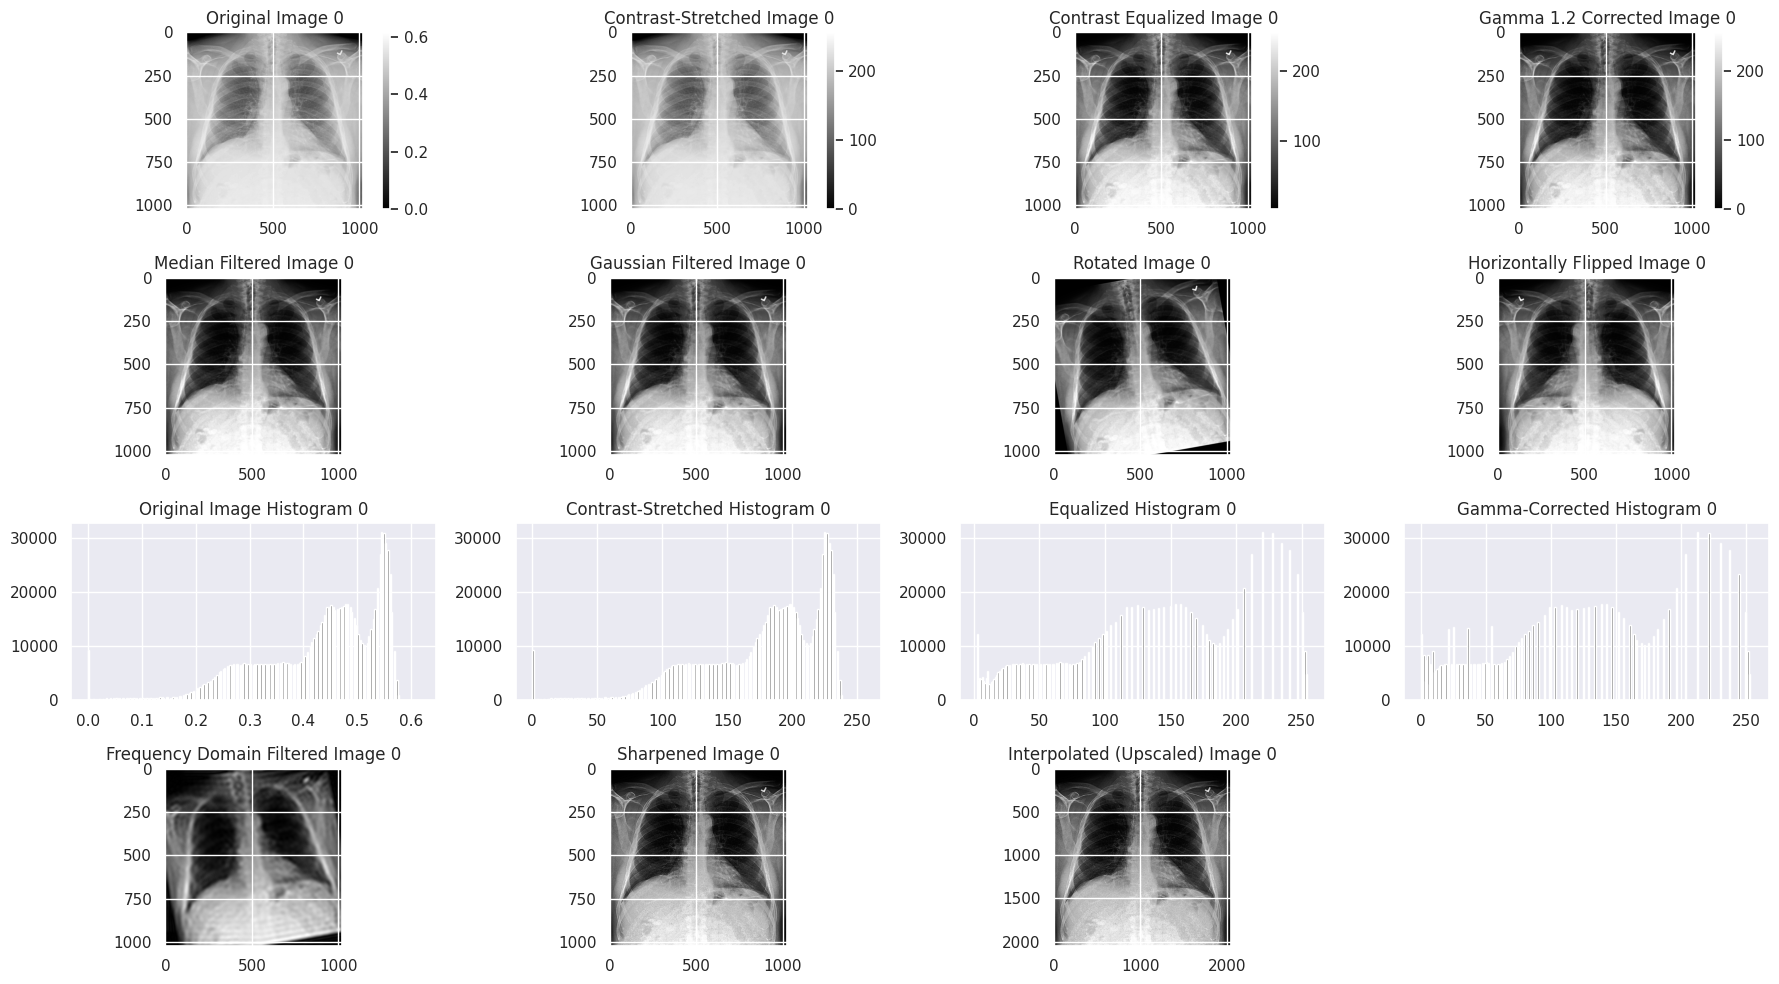

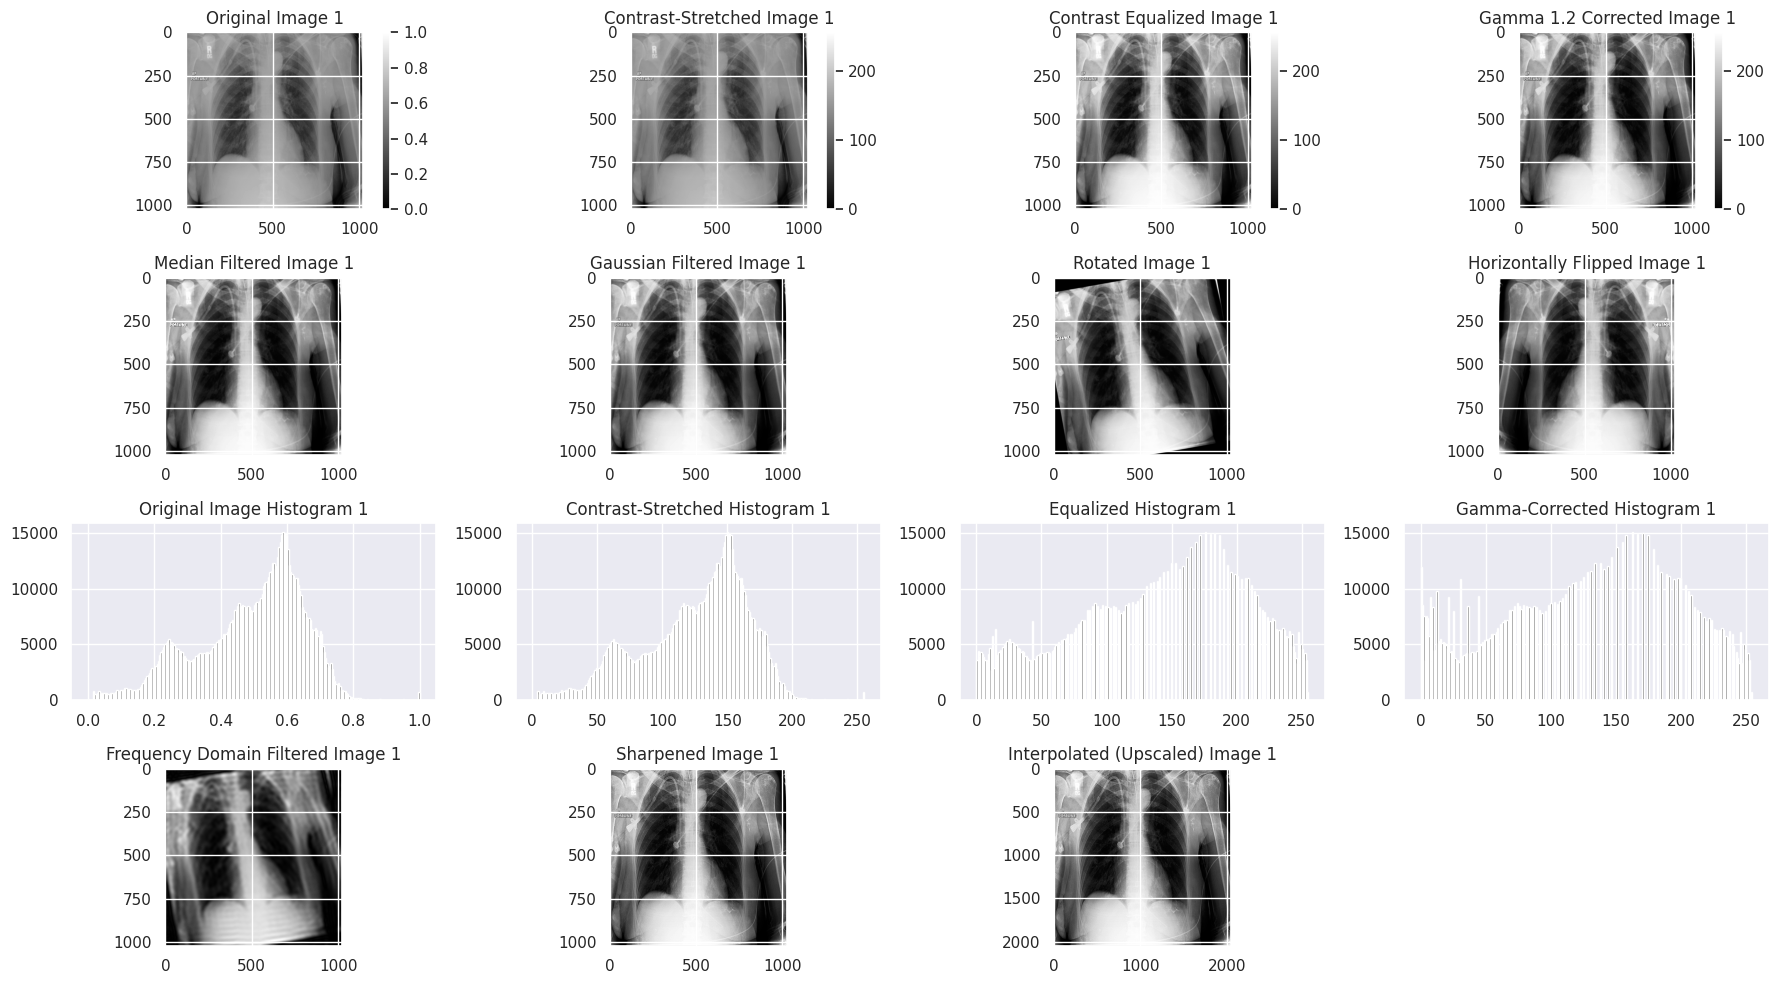

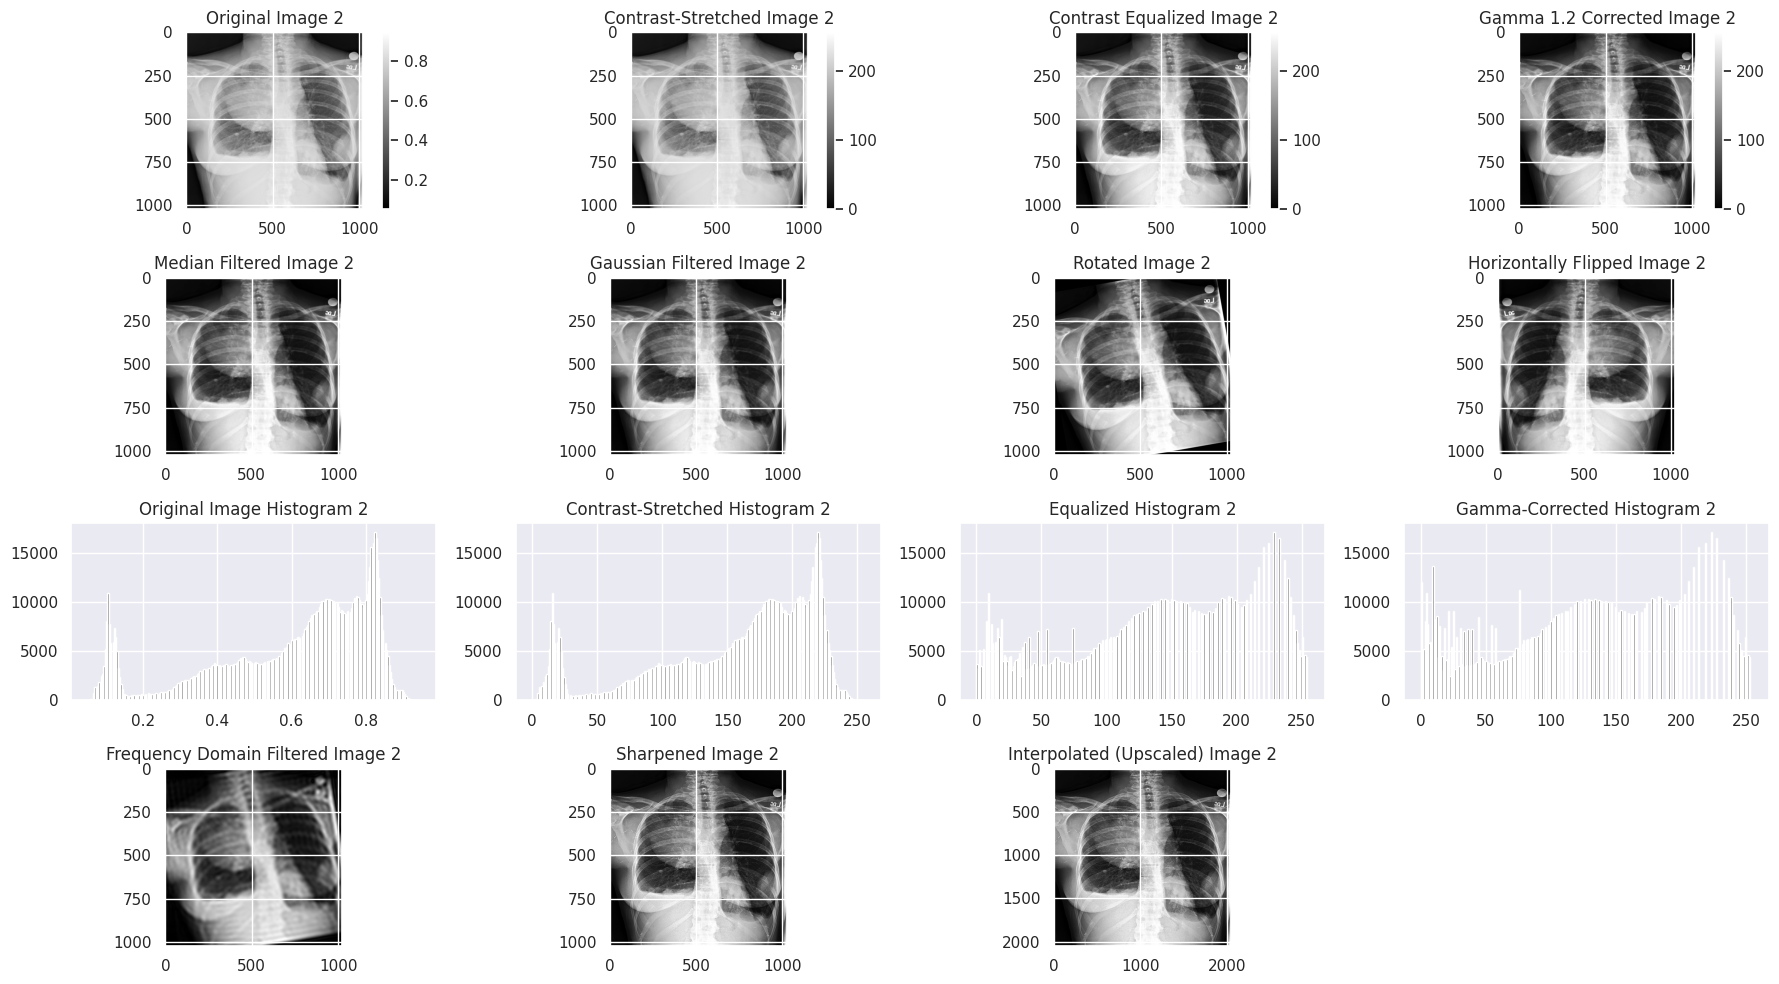

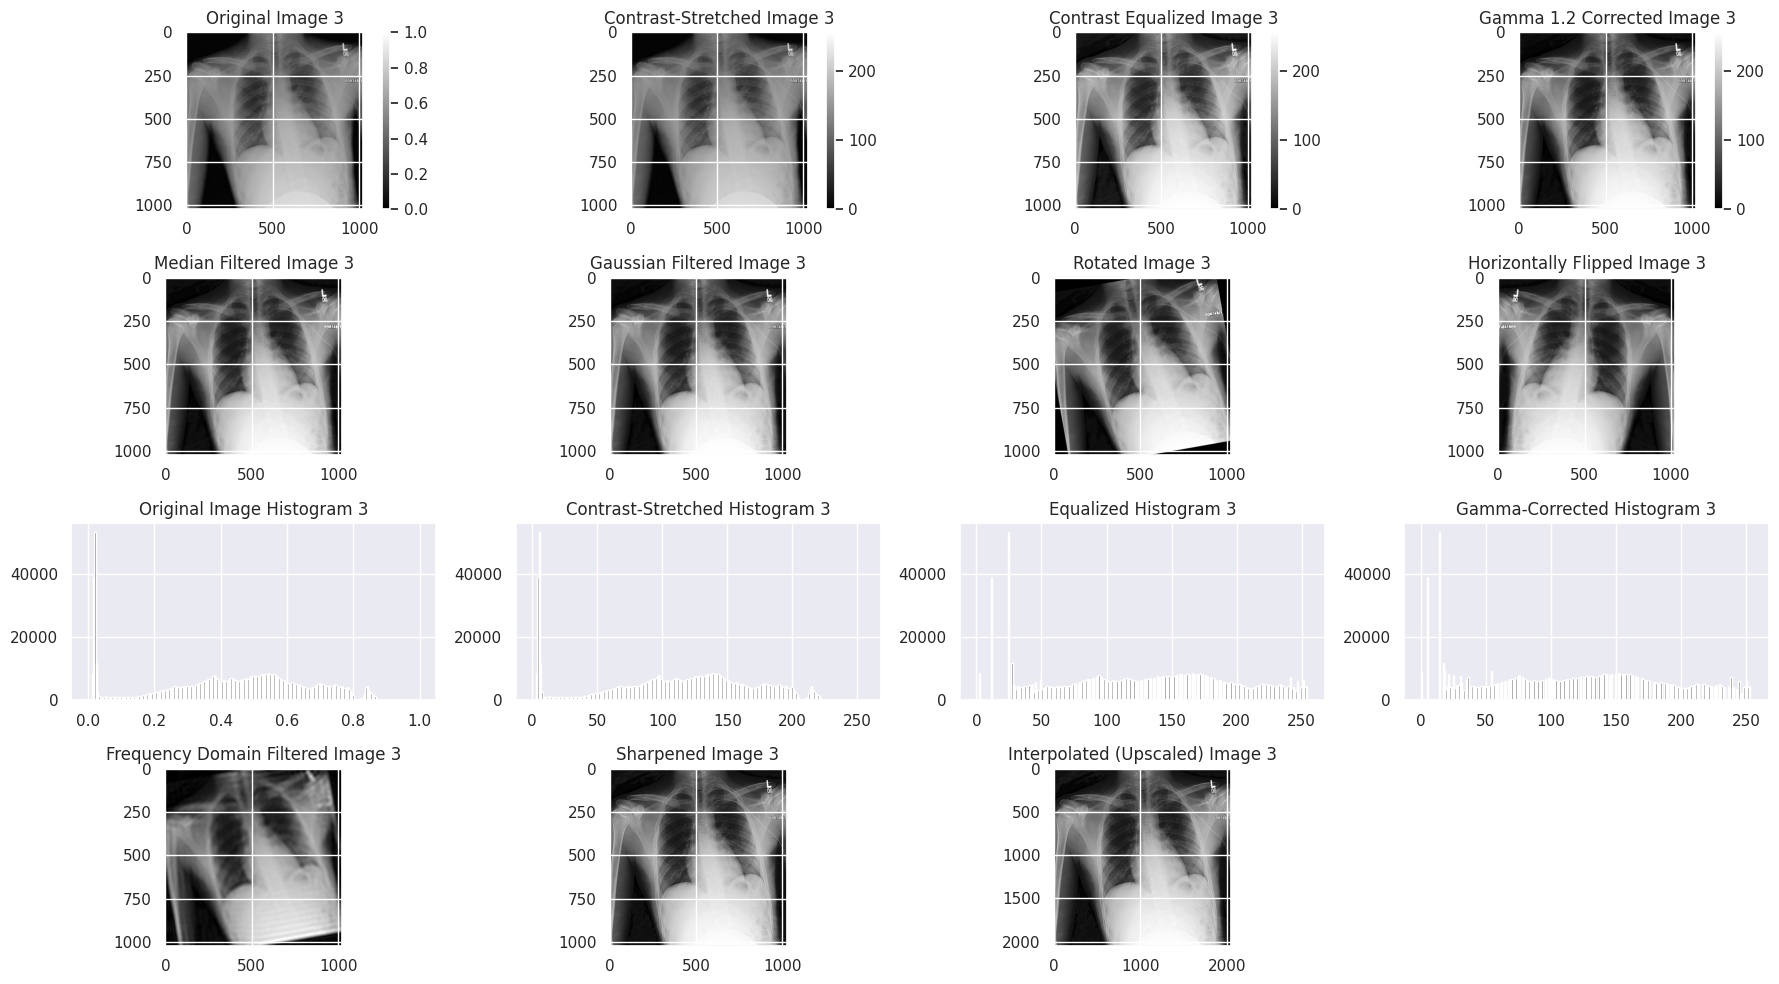

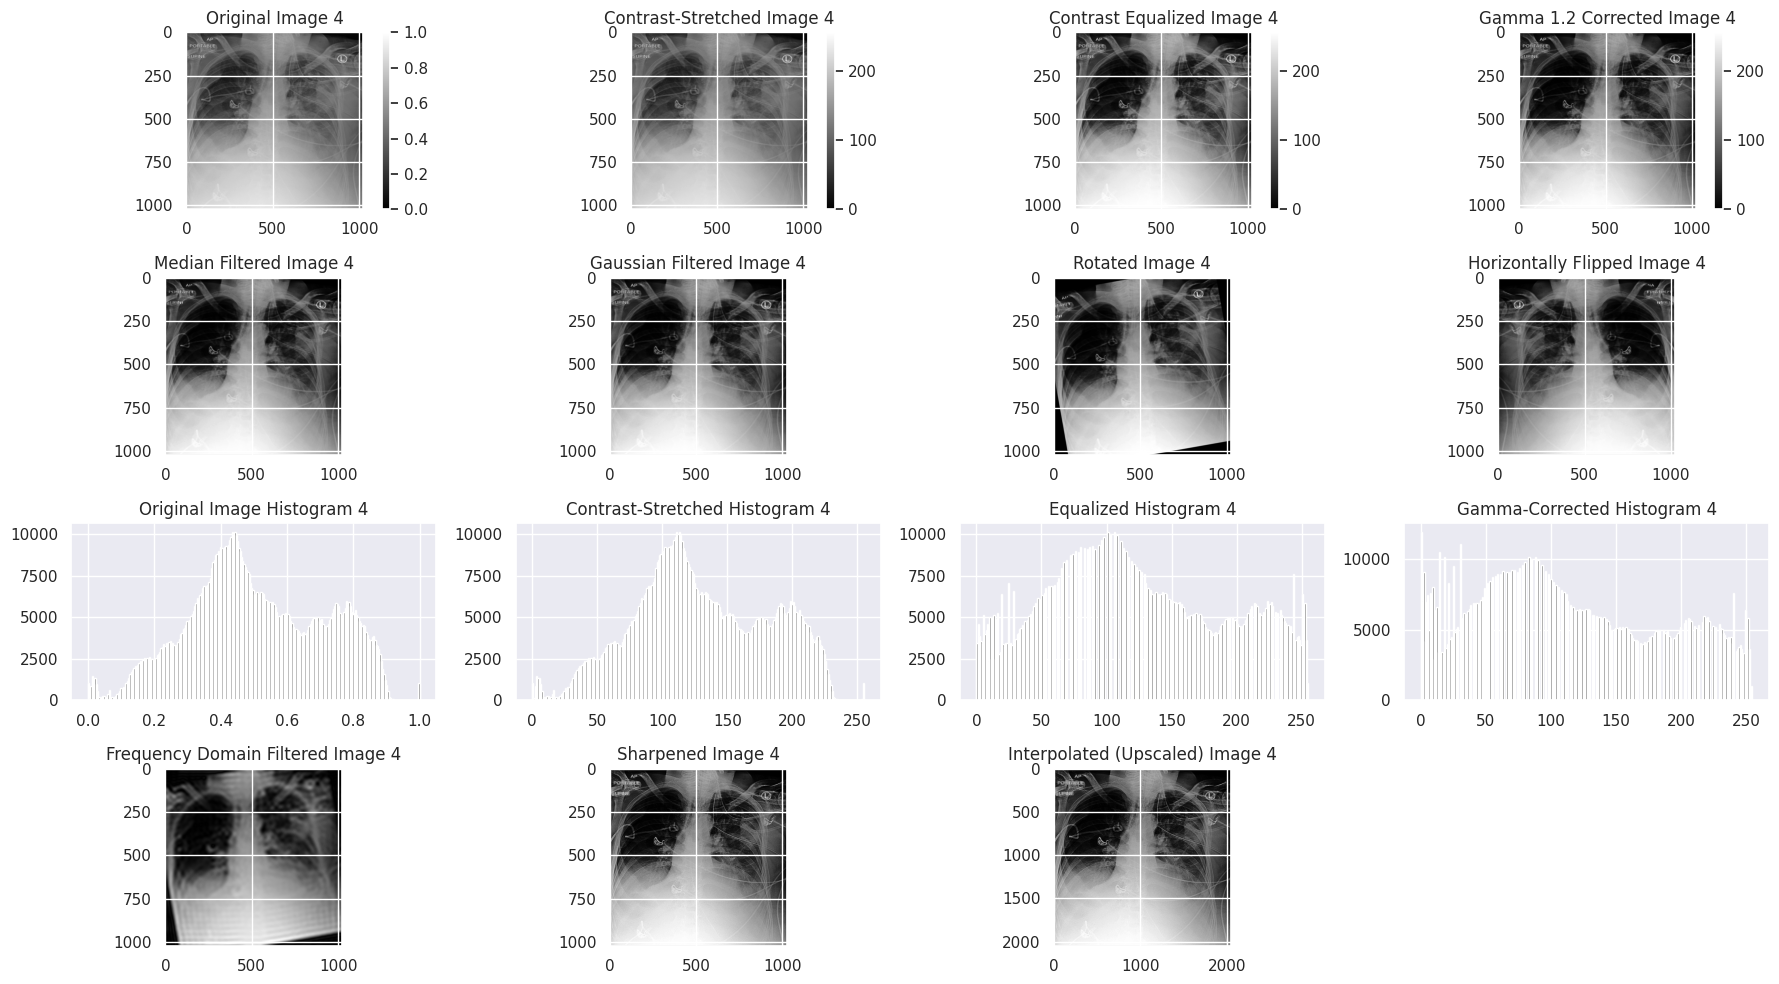

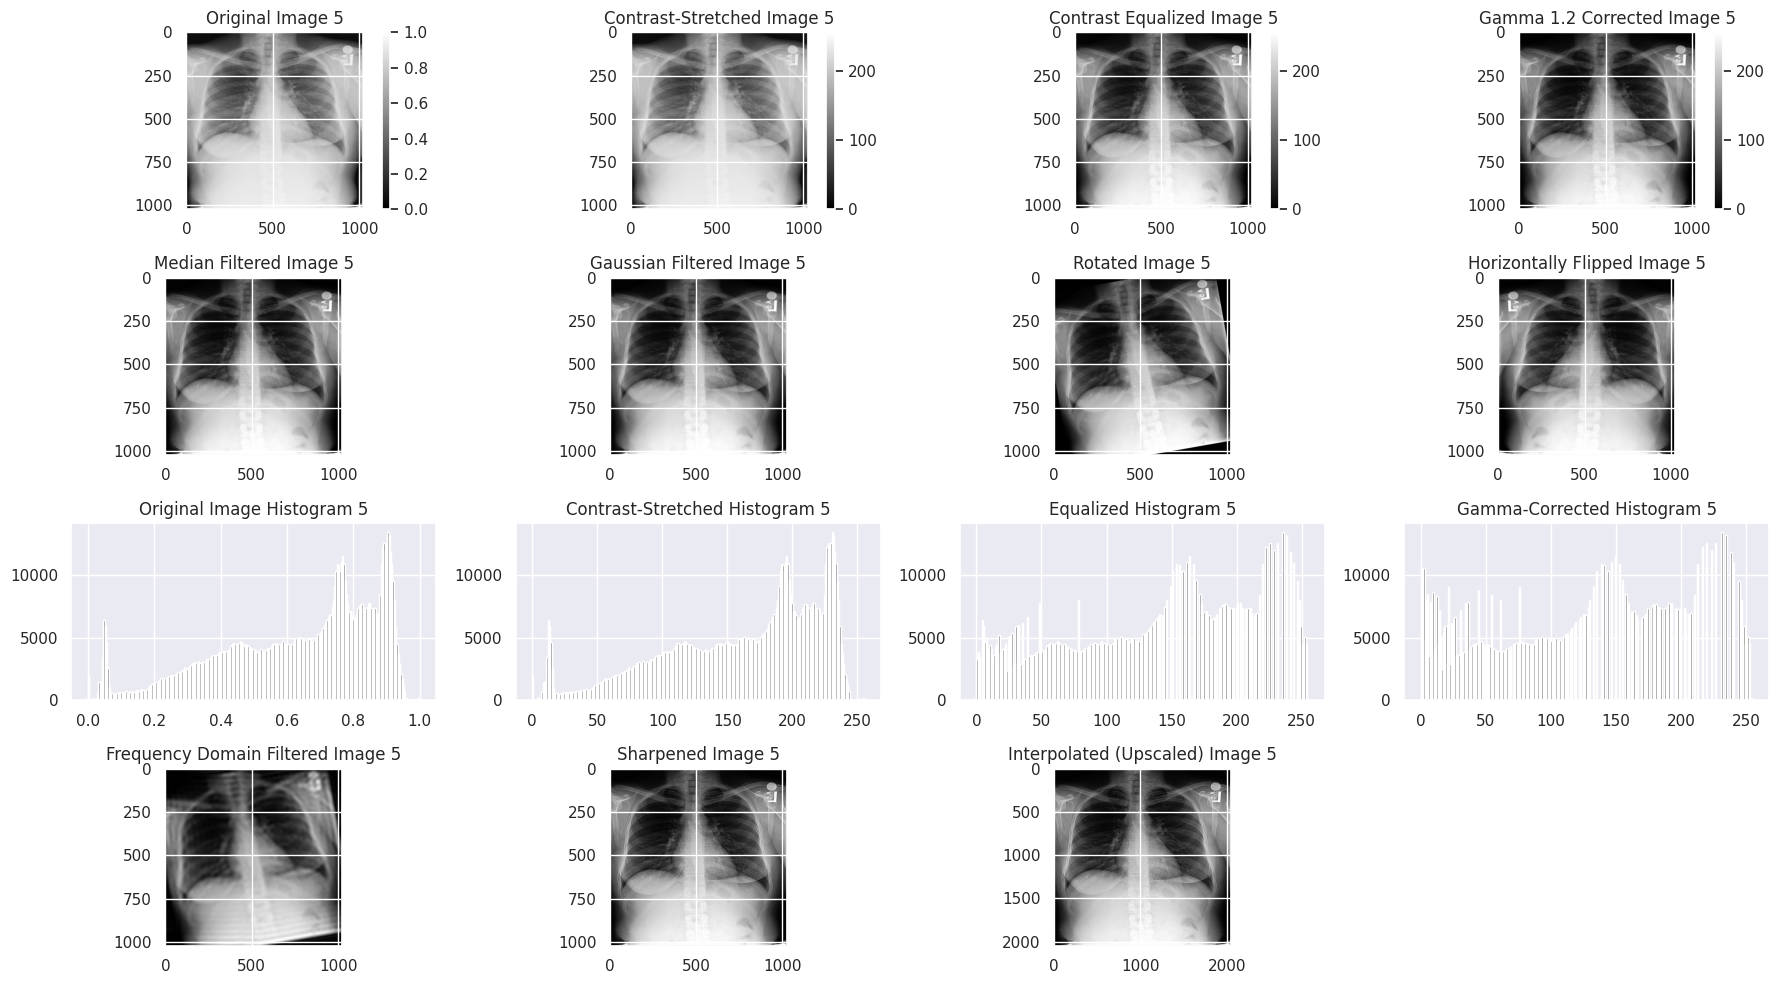

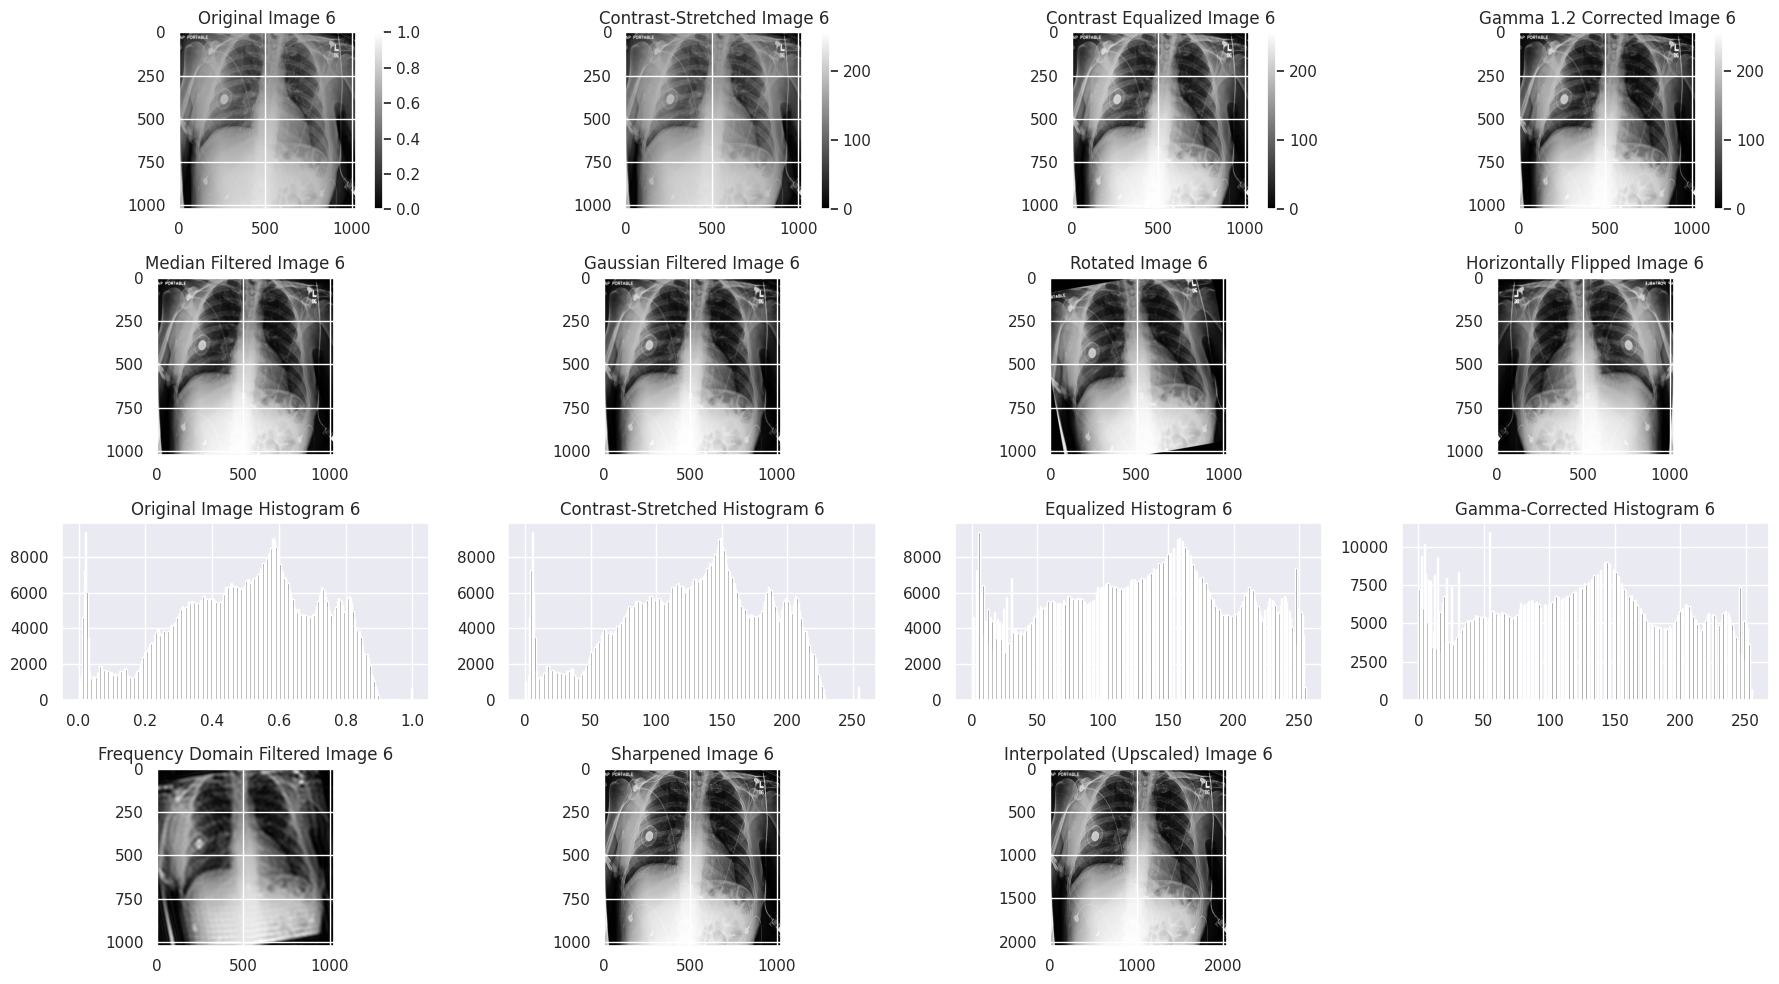

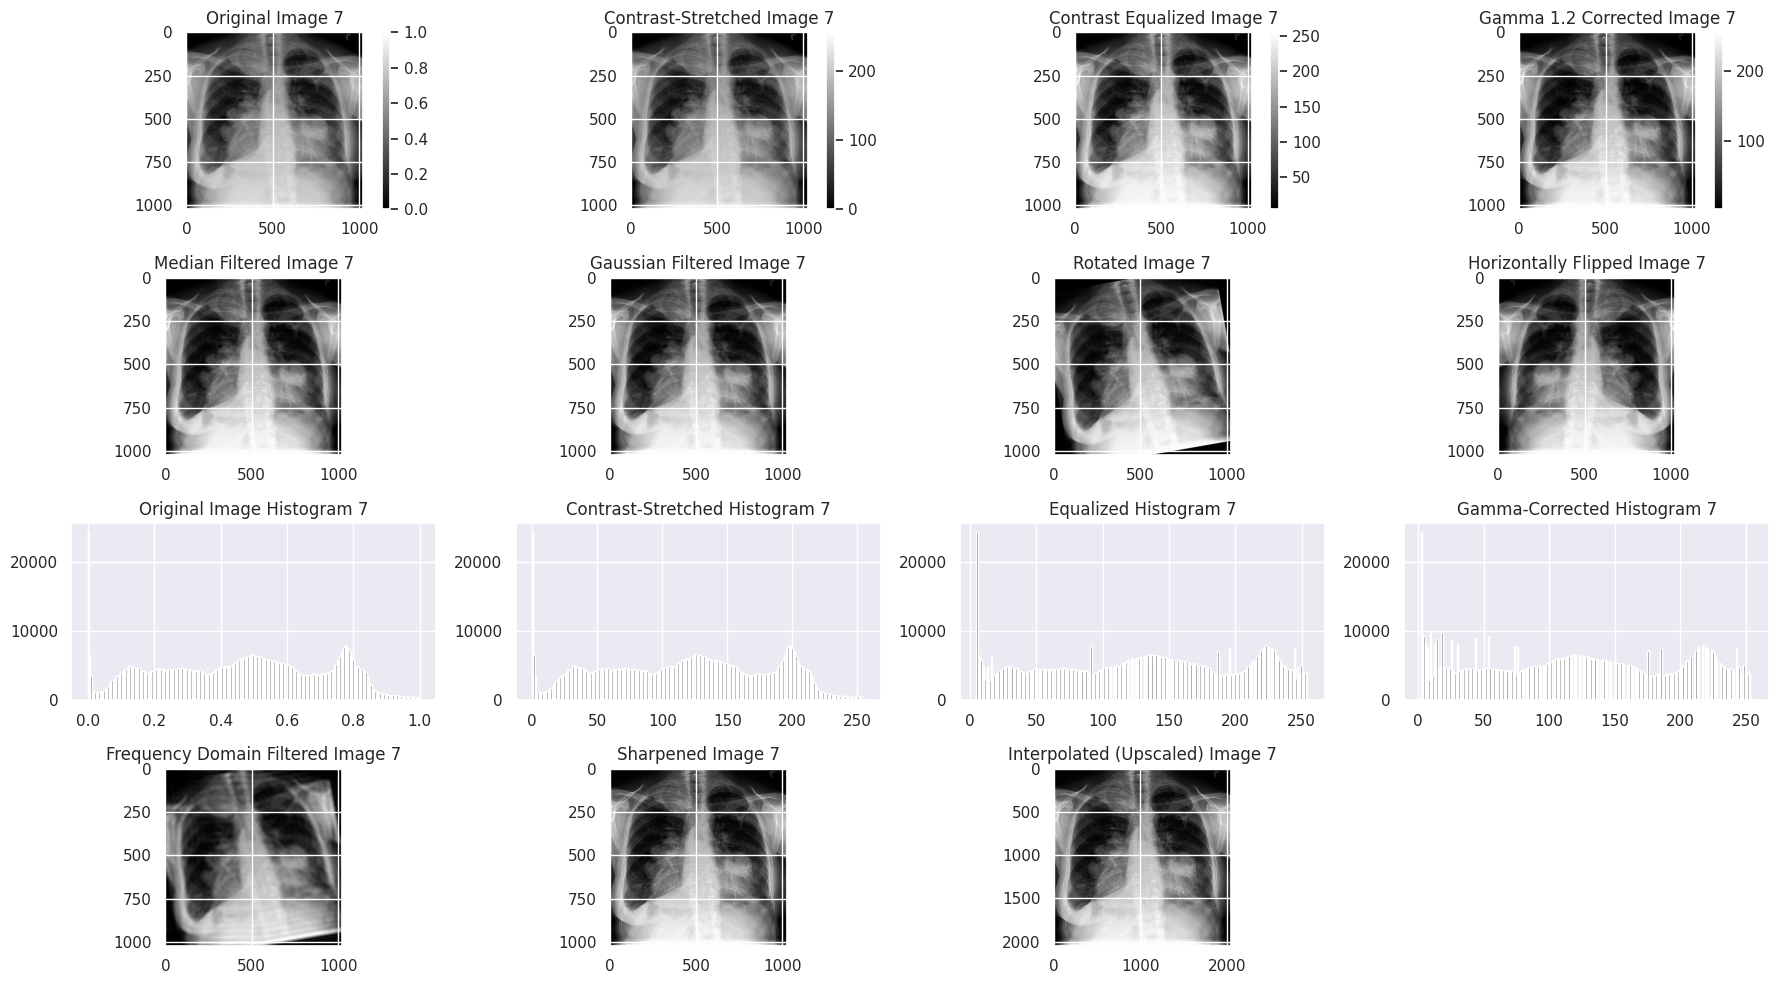

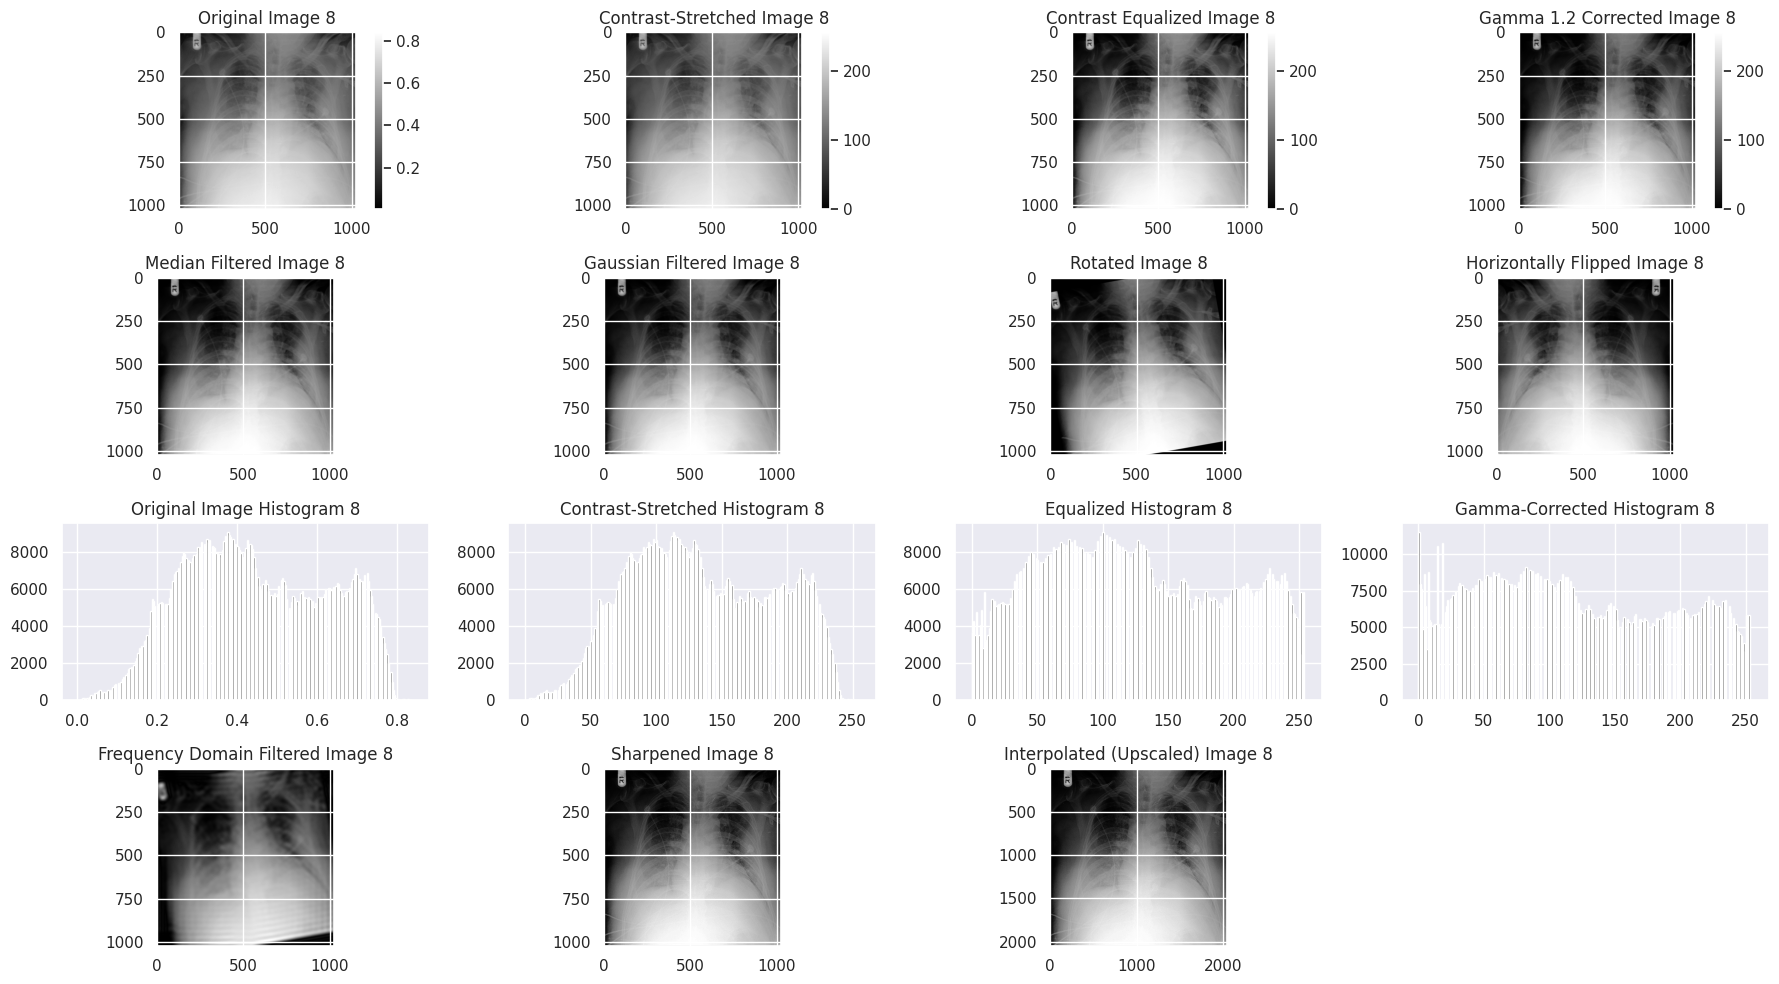

In [ ]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
sns.set()
from skimage import exposure
import cv2  # opencv for python package
from scipy.ndimage import zoom

!git clone https://github.com/hardik0/AI-for-Medicine-Specialization
%cd AI-for-Medicine-Specialization/AI-for-Medical-Diagnosis/

# Read csv file containing training datadata
train_df = pd.read_csv("nih/train-small.csv")
# Print first 5 rows
print(f'There are {train_df.shape[0]} rows and {train_df.shape[1]} columns in this data frame')
train_df.head()   #Dataframe'in ilk 5 satırnı döndürür

# Look at the data type of each column and whether null values are present
train_df.info()  #Dataframe'in özetini döndürüp yazdırır....

print(f"The total patient ids are {train_df['PatientId'].count()}, from those the unique ids are {train_df['PatientId'].value_counts().shape[0]} ")

columns = train_df.keys()  #sütun isimlerini döndürür...
columns = list(columns)
print(columns)

# Remove unnecesary elements
columns.remove('Image')      #Image sütununu kaldır
columns.remove('PatientId')  #PatientId sütununu kaldır
# Get the total classes
print(f"There are {len(columns)} columns of labels for these conditions: {columns}")

# Print out the number of positive labels for each class
for column in columns:
    print(f"The class {column} has {train_df[column].sum()} samples")

    # Extract numpy values from Image column in data frame
images = train_df['Image'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = 'nih/images_small/'

print('Display Random Images')

for i in range(9):

    raw_image = plt.imread(os.path.join(img_dir, random_images[i]))

    # Calculate minimum and maximum for contrast stretching
    min_val, max_val = raw_image.min(), raw_image.max()

    # Step 1: Apply contrast stretching
    min_val, max_val = raw_image.min(), raw_image.max()
    contrast_stretched = (raw_image - min_val) / (max_val - min_val)  # Normalize to [0, 1]
    contrast_stretched = (contrast_stretched * 255).astype(np.uint8)  # Scale to [0, 255] for visualization

    # Step 2: Apply histogram equalization after contrast stretching
    # Step 2: Apply histogram equalization using skimage
    equalized_image = exposure.equalize_hist(contrast_stretched)  # Returns values in [0, 1]
    equalized_image = (equalized_image * 255).astype(np.uint8)    # Scale to [0, 255]


    # Step 3: Apply gamma correction on the equalized image
    gamma = 1.2  # Adjust gamma value as needed
    gamma_corrected = np.power(equalized_image / 255.0, gamma) * 255
    gamma_corrected = gamma_corrected.astype(np.uint8)

    # Apply Median Filtering
    median_filtered = cv2.medianBlur(gamma_corrected, 5)
    # Apply Gaussian Blur
    gaussian_filtered = cv2.GaussianBlur(gamma_corrected, (5, 5), 0)

    # Example: Rotate the image by 10 degrees
    center = (median_filtered.shape[1] // 2, median_filtered.shape[0] // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, angle=10, scale=1.0)
    rotated_image = cv2.warpAffine(median_filtered, rotation_matrix, (median_filtered.shape[1], median_filtered.shape[0]))

    # Horizontal Flip
    flipped_horizontal = cv2.flip(median_filtered, 1)

    # Apply Fourier Transform and shift it to center low frequencies
    dft = cv2.dft(np.float32(rotated_image), flags=cv2.DFT_COMPLEX_OUTPUT)
    dft_shifted = np.fft.fftshift(dft)

    # Create a mask for filtering
    rows, cols = rotated_image.shape
    crow, ccol = rows // 2 , cols // 2
    mask = np.zeros((rows, cols, 2), np.uint8)
    mask[crow-30:crow+30, ccol-30:ccol+30] = 1  # Center low frequencies pass

    # Apply mask and inverse DFT
    fshift = dft_shifted * mask
    f_ishift = np.fft.ifftshift(fshift)
    filtered_image = cv2.idft(f_ishift)
    filtered_image = cv2.magnitude(filtered_image[:, :, 0], filtered_image[:, :, 1])

    # Step 4: Apply sharpening using an unsharp masking kernel
    sharpening_kernel = np.array([[-1, -1, -1],
                                  [-1,  9, -1],
                                  [-1, -1, -1]])
    sharpened_image = np.clip(cv2.filter2D(gamma_corrected, -1, sharpening_kernel), 0, 255).astype(np.uint8)
    # Step 5: Apply bicubic interpolation to upscale the image by a factor of 2
    scale_factor = 2
    resized_image = zoom(sharpened_image, scale_factor, order=3)  # Bicubic interpolation with `order=3`

    # Plot original image and histogram
    plt.figure(figsize=(18, 10))
    plt.subplot(4, 4, 1)
    plt.imshow(raw_image, cmap='gray')
    plt.title('Original Image'+' '+str(i))
    plt.colorbar()

    plt.subplot(4, 4, 5)
    plt.imshow(median_filtered, cmap='gray')
    plt.title("Median Filtered Image"+' '+str(i))

    plt.subplot(4, 4, 9)
    plt.hist(raw_image.ravel(), bins=256, color='gray')
    plt.title("Original Image Histogram"+' '+str(i))

    plt.subplot(4, 4, 13)
    # Normalize and display the filtered image
    filtered_image = cv2.normalize(filtered_image, None, 0, 255, cv2.NORM_MINMAX)
    plt.imshow(filtered_image, cmap='gray')
    plt.title("Frequency Domain Filtered Image"+' '+str(i))


    # Plot contrast-stretched image and histogram
    plt.subplot(4, 4, 2)
    plt.imshow(contrast_stretched, cmap='gray')
    plt.title('Contrast-Stretched Image'+' '+str(i))
    plt.colorbar()

    plt.subplot(4, 4, 6)
    plt.imshow(gaussian_filtered, cmap='gray')
    plt.title("Gaussian Filtered Image"+' '+str(i))

    plt.subplot(4, 4, 10)
    plt.hist(contrast_stretched.ravel(), bins=256, color='gray')
    plt.title("Contrast-Stretched Histogram"+' '+str(i))

    plt.subplot(4, 4, 14)
    plt.imshow(sharpened_image, cmap='gray')
    plt.title("Sharpened Image"+' '+str(i))


    # Plot contrast-equalized image and histogram
    plt.subplot(4, 4, 3)
    plt.imshow(equalized_image, cmap='gray')
    plt.title('Contrast Equalized Image'+' '+str(i))
    plt.colorbar()

    plt.subplot(4, 4, 7)
    plt.imshow(rotated_image, cmap='gray')
    plt.title("Rotated Image"+' '+str(i))

    plt.subplot(4, 4, 11)
    plt.hist(equalized_image.ravel(), bins=256, color='gray')
    plt.title("Equalized Histogram"+' '+str(i))

    plt.subplot(4, 4, 15)
    plt.imshow(resized_image, cmap='gray')
    plt.title("Interpolated (Upscaled) Image"+' '+str(i))

    # Plot gamma-corrected image and histogram
    plt.subplot(4, 4, 4)
    plt.imshow(gamma_corrected, cmap='gray')
    plt.title(f'Gamma '+str(gamma)+' Corrected Image'+' '+str(i))
    plt.colorbar()

    plt.subplot(4, 4, 8)
    plt.imshow(flipped_horizontal, cmap='gray')
    plt.title("Horizontally Flipped Image"+' '+str(i))

    plt.subplot(4, 4, 12)
    plt.hist(gamma_corrected.ravel(), bins=256, color='gray')
    plt.title("Gamma-Corrected Histogram"+' '+str(i))

    #plt.subplot(4, 4, 16)

    plt.tight_layout()
    plt.show()